In [6]:
from tensorforce.environments import Environment
import tensorforce
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from threading import Thread

# a bit hacky, but meeehh... FIXME!!
import sys
import os
cwd = os.getcwd()
sys.path.append(cwd + "/../Simulation/")

from dolfin import Expression, File, plot
from WorkingProbes import PenetratedDragProbeANN, PenetratedLiftProbeANN, PressureProbeANN, VelocityProbeANN, RecirculationAreaProbe
from WorkingMshGenerator import generate_mesh
from WorkingFlowSolver import FlowSolver
from WorkingMshConvert import convert
from dolfin import *

import numpy as np
import os

import pickle

import time
import math
import csv

import shutil

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [7]:
def constant_profile(mesh, degree):
    '''
    Time independent inflow profile.
    '''
    bot = mesh.coordinates().min(axis=0)[1]
    top = mesh.coordinates().max(axis=0)[1]

    H = top - bot

    Um = 1.5

    return Expression(('-4*Um*(x[1]-bot)*(x[1]-top)/H/H',
                       '0'), bot=bot, top=top, H=H, Um=Um, degree=degree, time=0)

In [8]:
class RingBuffer():
    "A 1D ring buffer using numpy arrays"
    def __init__(self, length):
        self.data = np.zeros(length, dtype='f')
        self.index = 0

    def extend(self, x):
        "adds array x to ring buffer"
        x_index = (self.index + np.arange(x.size)) % self.data.size
        self.data[x_index] = x
        self.index = x_index[-1] + 1

    def get(self):
        "Returns the first-in-first-out data in the ring buffer"
        idx = (self.index + np.arange(self.data.size)) % self.data.size
        return self.data[idx]

In [9]:
class Env2DCylinder(Environment):
    """Environment for 2D flow simulation around a cylinder."""

    def __init__(self, path_root, geometry_params, flow_params, solver_params, output_params,
                 optimization_params, inspection_params, n_iter_make_ready=None, verbose=0, size_history=2000,
                 reward_function='plain_drag', size_time_state=50, number_steps_execution=1, simu_name="Simu"):
        """

        """

        # TODO: should actually save the dicts in to double check when loading that using compatible simulations together

        #printi("--- call init ---")

        self.observation = None
        self.thread = None

        self.path_root = path_root
        self.flow_params = flow_params
        self.geometry_params = geometry_params
        self.solver_params = solver_params
        self.output_params = output_params
        self.optimization_params = optimization_params
        self.inspection_params = inspection_params
        self.verbose = verbose
        self.n_iter_make_ready = n_iter_make_ready
        self.size_history = size_history
        self.reward_function = reward_function
        self.size_time_state = size_time_state
        self.number_steps_execution = number_steps_execution

        self.simu_name = simu_name


        #Relatif a l'ecriture des .csv
        name="output.csv"
        last_row = None
        if(os.path.exists("saved_models/"+name)):
            with open("saved_models/"+name, 'r') as f:
                for row in reversed(list(csv.reader(f, delimiter=";", lineterminator="\n"))):
                    last_row = row
                    break
        if(not last_row is None):
            self.episode_number = int(last_row[0])
            self.last_episode_number = int(last_row[0])
        else:
            self.last_episode_number = 0
            self.episode_number = 0
        self.episode_drags = np.array([])
        self.episode_areas = np.array([])
        self.episode_lifts = np.array([])

        self.initialized_visualization = False

        self.start_class()

        #printi("--- done init ---")

    def start_class(self):
        self.solver_step = 0
        self.accumulated_drag = 0
        self.accumulated_lift = 0

        self.initialized_output = False

        self.resetted_number_probes = False

        self.area_probe = None

        self.history_parameters = {}

        for crrt_jet in range(len(self.geometry_params["jet_positions"])):
            self.history_parameters["jet_{}".format(crrt_jet)] = RingBuffer(self.size_history)

        self.history_parameters["number_of_jets"] = len(self.geometry_params["jet_positions"])

        for crrt_probe in range(len(self.output_params["locations"])):
            if self.output_params["probe_type"] == 'pressure':
                self.history_parameters["probe_{}".format(crrt_probe)] = RingBuffer(self.size_history)
            elif self.output_params["probe_type"] == 'velocity':
                self.history_parameters["probe_{}_u".format(crrt_probe)] = RingBuffer(self.size_history)
                self.history_parameters["probe_{}_v".format(crrt_probe)] = RingBuffer(self.size_history)

        self.history_parameters["number_of_probes"] = len(self.output_params["locations"])

        self.history_parameters["drag"] = RingBuffer(self.size_history)
        self.history_parameters["lift"] = RingBuffer(self.size_history)
        self.history_parameters["recirc_area"] = RingBuffer(self.size_history)

        # ------------------------------------------------------------------------
        # remesh if necessary
        h5_file = '.'.join([self.path_root, 'h5'])
        msh_file = '.'.join([self.path_root, 'msh'])
        self.geometry_params['mesh'] = h5_file

        # Regenerate mesh?
        if self.geometry_params['remesh']:

            if self.verbose > 0:
                print("Remesh")
                #printi("generate_mesh start...")

            generate_mesh(self.geometry_params, template=self.geometry_params['template'])

            if self.verbose > 0:
                print("generate_mesh done!")
            print(msh_file)
            assert os.path.exists(msh_file)

            convert(msh_file, h5_file)
            assert os.path.exists(h5_file)

        # ------------------------------------------------------------------------
        # if necessary, load initialization fields
        if self.n_iter_make_ready is None:
            if self.verbose > 0:
                print("Load initial flow")

            self.flow_params['u_init'] = 'mesh/u_init.xdmf'
            self.flow_params['p_init'] = 'mesh/p_init.xdmf'

            if self.verbose > 0:
                print("Load buffer history")

            with open('mesh/dict_history_parameters.pkl', 'rb') as f:
                self.history_parameters = pickle.load(f)

            if not "number_of_probes" in self.history_parameters:
                self.history_parameters["number_of_probes"] = 0

            if not "number_of_jets" in self.history_parameters:
                self.history_parameters["number_of_jets"] = len(self.geometry_params["jet_positions"])
                #printi("Warning!! The number of jets was not set in the loaded hdf5 file")

            if not "lift" in self.history_parameters:
                self.history_parameters["lift"] = RingBuffer(self.size_history)
                #printi("Warning!! No value for the lift founded")

            if not "recirc_area" in self.history_parameters:
                self.history_parameters["recirc_area"] = RingBuffer(self.size_history)
                #printi("Warning!! No value for the recirculation area founded")

            # if not the same number of probes, reset
            if not self.history_parameters["number_of_probes"] == len(self.output_params["locations"]):
                for crrt_probe in range(len(self.output_params["locations"])):
                    if self.output_params["probe_type"] == 'pressure':
                        self.history_parameters["probe_{}".format(crrt_probe)] = RingBuffer(self.size_history)
                    elif self.output_params["probe_type"] == 'velocity':
                        self.history_parameters["probe_{}_u".format(crrt_probe)] = RingBuffer(self.size_history)
                        self.history_parameters["probe_{}_v".format(crrt_probe)] = RingBuffer(self.size_history)

                self.history_parameters["number_of_probes"] = len(self.output_params["locations"])

                #printi("Warning!! Number of probes was changed! Probes buffer content reseted")

                self.resetted_number_probes = True

        # ------------------------------------------------------------------------
        # create the flow simulation object
        self.flow = FlowSolver(self.flow_params, self.geometry_params, self.solver_params)

        # ------------------------------------------------------------------------
        # Setup probes
        if self.output_params["probe_type"] == 'pressure':
            self.ann_probes = PressureProbeANN(self.flow, self.output_params['locations'])

        elif self.output_params["probe_type"] == 'velocity':
            self.ann_probes = VelocityProbeANN(self.flow, self.output_params['locations'])
        else:
            raise RuntimeError("unknown probe type")

        # Setup drag measurement
        self.drag_probe = PenetratedDragProbeANN(self.flow)
        self.lift_probe = PenetratedLiftProbeANN(self.flow)

        # ------------------------------------------------------------------------
        # No flux from jets for starting
        self.Qs = np.zeros(len(self.geometry_params['jet_positions']))
        self.action = np.zeros(len(self.geometry_params['jet_positions']))

        # ------------------------------------------------------------------------
        # prepare the arrays for plotting positions
        self.compute_positions_for_plotting()


        # ------------------------------------------------------------------------
        # if necessary, make converge
        if self.n_iter_make_ready is not None:
            self.u_, self.p_ = self.flow.evolve(self.Qs)
            path=''
            if "dump" in self.inspection_params:
                path = 'results/area_out.pvd'
            self.area_probe = RecirculationAreaProbe(self.u_, 0, store_path=path)
            if self.verbose > 0:
                print("Compute initial flow")
                #printiv(self.n_iter_make_ready)

            for _ in range(self.n_iter_make_ready):
                self.u_, self.p_ = self.flow.evolve(self.Qs)
                self.probes_values = self.ann_probes.sample(self.u_, self.p_).flatten()
                self.drag = self.drag_probe.sample(self.u_, self.p_)
                self.lift = self.lift_probe.sample(self.u_, self.p_)
                self.recirc_area = self.area_probe.sample(self.u_, self.p_)

                self.write_history_parameters()
                self.visual_inspection()
                self.output_data()

                self.solver_step += 1

        if self.n_iter_make_ready is not None:
            encoding = XDMFFile.Encoding.HDF5
            mesh = convert(msh_file, h5_file)
            comm = mesh.mpi_comm()

            # save field data
            XDMFFile(comm, 'mesh/u_init.xdmf').write_checkpoint(self.u_, 'u0', 0, encoding)
            XDMFFile(comm, 'mesh/p_init.xdmf').write_checkpoint(self.p_, 'p0', 0, encoding)

            # save buffer dict
            with open('mesh/dict_history_parameters.pkl', 'wb') as f:
                pickle.dump(self.history_parameters, f, pickle.HIGHEST_PROTOCOL)

        # ----------------------------------------------------------------------
        # if reading from disk, show to check everything ok
        if self.n_iter_make_ready is None:
            #Let's start in a random position of the vortex shading
            if self.optimization_params["random_start"]:
                rd_advancement = np.random.randint(650)
                for j in range(rd_advancement):
                    self.flow.evolve(self.Qs)
                print("Simulated {} iterations before starting the control".format(rd_advancement))

            self.u_, self.p_ = self.flow.evolve(self.Qs)
            path=''
            if "dump" in self.inspection_params:
                path = 'results/area_out.pvd'
            self.area_probe = RecirculationAreaProbe(self.u_, 0, store_path=path)

            self.probes_values = self.ann_probes.sample(self.u_, self.p_).flatten()
            self.drag = self.drag_probe.sample(self.u_, self.p_)
            self.lift = self.lift_probe.sample(self.u_, self.p_)
            self.recirc_area = self.area_probe.sample(self.u_, self.p_)

            self.write_history_parameters()
            # self.visual_inspection()
            # self.output_data()

            # self.solver_step += 1

            # time.sleep(10)

        # ----------------------------------------------------------------------
        # if necessary, fill the probes buffer
        if self.resetted_number_probes:
            #printi("Need to fill again the buffer; modified number of probes")

            for _ in range(self.size_history):
                self.execute()

        # ----------------------------------------------------------------------
        # ready now

        #Initialisation du prob de recirculation area
        #path=''
        #if "dump" in self.inspection_params:
        #    path = 'results/area_out.pvd'
        #self.area_probe = RecirculationAreaProbe(self.u_, 0, store_path=path)

        self.ready_to_use = True

    def write_history_parameters(self):
        for crrt_jet in range(len(self.geometry_params["jet_positions"])):
            self.history_parameters["jet_{}".format(crrt_jet)].extend(self.Qs[crrt_jet])

        if self.output_params["probe_type"] == 'pressure':
            for crrt_probe in range(len(self.output_params["locations"])):
                self.history_parameters["probe_{}".format(crrt_probe)].extend(self.probes_values[crrt_probe])
        elif self.output_params["probe_type"] == 'velocity':
            for crrt_probe in range(len(self.output_params["locations"])):
                self.history_parameters["probe_{}_u".format(crrt_probe)].extend(self.probes_values[2 * crrt_probe])
                self.history_parameters["probe_{}_v".format(crrt_probe)].extend(self.probes_values[2 * crrt_probe + 1])

        self.history_parameters["drag"].extend(np.array(self.drag))
        self.history_parameters["lift"].extend(np.array(self.lift))
        self.history_parameters["recirc_area"].extend(np.array(self.recirc_area))

    def compute_positions_for_plotting(self):
        # where the pressure probes are
        self.list_positions_probes_x = []
        self.list_positions_probes_y = []

        # total_number_of_probes = len(self.output_params['locations'])

        #printiv(total_number_of_probes)

        # get the positions
        for crrt_probe in self.output_params['locations']:
            if self.verbose > 2:
                print(crrt_probe)

            self.list_positions_probes_x.append(crrt_probe[0])
            self.list_positions_probes_y.append(crrt_probe[1])

        # where the jets are
        radius_cylinder = self.geometry_params['cylinder_size'] / 2.0 / self.geometry_params['clscale']
        self.list_positions_jets_x = []
        self.list_positions_jets_y = []

        # compute the positions
        for crrt_jet_angle in self.geometry_params['jet_positions']:
            crrt_jet_angle_rad = math.pi / 180.0 * crrt_jet_angle
            crrt_x = radius_cylinder * math.cos(crrt_jet_angle_rad)
            crrt_y = radius_cylinder * math.sin(crrt_jet_angle_rad)
            self.list_positions_jets_x.append(crrt_x)
            self.list_positions_jets_y.append(1.1 * crrt_y)

    def show_flow(self):
        plt.figure()
        plot(self.u_)
        plt.scatter(self.list_positions_probes_x, self.list_positions_probes_y, c='k', marker='o')
        plt.scatter(self.list_positions_jets_x, self.list_positions_jets_y, c='r', marker='o')
        plt.xlim([-self.geometry_params['front_distance'], self.geometry_params['length'] - self.geometry_params['front_distance']])
        plt.ylim([-self.geometry_params['bottom_distance'], self.geometry_params['width'] - self.geometry_params['bottom_distance']])
        plt.ylabel("Y")
        plt.xlabel("X")
        plt.show()

        plt.figure()
        p = plot(self.p_)
        cb = plt.colorbar(p, fraction=0.1, shrink=0.3)
        plt.scatter(self.list_positions_probes_x, self.list_positions_probes_y, c='k', marker='o')
        plt.scatter(self.list_positions_jets_x, self.list_positions_jets_y, c='r', marker='o')
        plt.xlim([-self.geometry_params['front_distance'], self.geometry_params['length'] - self.geometry_params['front_distance']])
        plt.ylim([-self.geometry_params['bottom_distance'], self.geometry_params['width'] - self.geometry_params['bottom_distance']])
        plt.ylabel("Y")
        plt.xlabel("X")
        plt.tight_layout()
        cb.set_label("P")
        plt.show()

    def show_control(self):
        plt.figure()

        linestyles = ['-', '--', ':', '-.']

        for crrt_jet in range(len(self.geometry_params["jet_positions"])):
            crrt_jet_data = self.history_parameters["jet_{}".format(crrt_jet)].get()
            plt.plot(crrt_jet_data, label="jet {}".format(crrt_jet), linestyle=linestyles[crrt_jet], linewidth=1.5)
        plt.legend(loc=2)
        plt.ylabel("control Q")
        plt.xlabel("actuation step")
        plt.tight_layout()
        plt.pause(1.0)
        plt.savefig("saved_figures/control_episode_{}.pdf".format(self.episode_number))
        plt.show()
        plt.pause(2.0)

    def show_drag(self):
        plt.figure()
        crrt_drag = self.history_parameters["drag"].get()
        plt.plot(crrt_drag, label="episode drag", linewidth=1.2)
        plt.plot([0, self.size_history - 1], [self.inspection_params['line_drag'], self.inspection_params['line_drag']], label="mean drag no control", linewidth=2.5, linestyle="--")
        plt.ylabel("measured drag D")
        plt.xlabel("actuation step")
        range_drag_plot = self.inspection_params["range_drag_plot"]
        plt.legend(loc=2)
        plt.ylim(range_drag_plot)
        plt.tight_layout()
        plt.pause(1.0)
        plt.savefig("saved_figures/drag_episode_{}.pdf".format(self.episode_number))
        plt.show()
        plt.pause(2.0)

    def visual_inspection(self):
        total_number_subplots = 5
        crrt_subplot = 1

        if(not self.initialized_visualization and self.inspection_params["plot"] != False):
            plt.ion()
            plt.subplots(total_number_subplots, 1)
            # ax.set_xlim([0, self.nbr_points_animate_plot])
            # ax.set_ylim([0, 1024])

            self.initialized_visualization = True

        if("plot" in self.inspection_params and self.inspection_params["plot"] != False):
            modulo_base = self.inspection_params["plot"]

            if self.solver_step % modulo_base == 0:

                plt.subplot(total_number_subplots, 1, crrt_subplot)
                plot(self.u_)
                plt.scatter(self.list_positions_probes_x, self.list_positions_probes_y, c='k', marker='o')
                plt.scatter(self.list_positions_jets_x, self.list_positions_jets_y, c='r', marker='o')
                plt.xlim([-self.geometry_params['front_distance'], self.geometry_params['length'] - self.geometry_params['front_distance']])
                plt.ylim([-self.geometry_params['bottom_distance'], self.geometry_params['width'] - self.geometry_params['bottom_distance']])
                plt.ylabel("V")
                crrt_subplot += 1

                plt.subplot(total_number_subplots, 1, crrt_subplot)
                plot(self.p_)
                plt.scatter(self.list_positions_probes_x, self.list_positions_probes_y, c='k', marker='o')
                plt.scatter(self.list_positions_jets_x, self.list_positions_jets_y, c='r', marker='o')
                plt.xlim([-self.geometry_params['front_distance'], self.geometry_params['length'] - self.geometry_params['front_distance']])
                plt.ylim([-self.geometry_params['bottom_distance'], self.geometry_params['width'] - self.geometry_params['bottom_distance']])
                plt.ylabel("P")
                crrt_subplot += 1

                plt.subplot(total_number_subplots, 1, crrt_subplot)
                plt.cla()
                for crrt_jet in range(len(self.geometry_params["jet_positions"])):
                    crrt_jet_data = self.history_parameters["jet_{}".format(crrt_jet)].get()
                    plt.plot(crrt_jet_data, label="jet {}".format(crrt_jet))
                plt.legend(loc=6)
                plt.ylabel("M.F.R.")
                crrt_subplot += 1

                # plt.subplot(total_number_subplots, 1, crrt_subplot)
                # plt.cla()
                # for crrt_probe in range(len(self.output_params["locations"])):
                #     if self.output_params["probe_type"] == 'pressure':
                #         crrt_probe_data = self.history_parameters["probe_{}".format(crrt_probe)].get()
                #         plt.plot(crrt_probe_data, label="probe {}".format(crrt_probe))
                #     elif self.output_params["probe_type"] == 'velocity':
                #         crrt_probe_data = self.history_parameters["probe_{}_u".format(crrt_probe)].get()
                #         plt.plot(crrt_probe_data, label="probe {}".format(crrt_probe))
                #         crrt_probe_data = self.history_parameters["probe_{}_v".format(crrt_probe)].get()
                #         plt.plot(crrt_probe_data, label="probe {}".format(crrt_probe))
                # # plt.legend(loc=6)
                # if self.output_params["probe_type"] == "pressure":
                #     plt.ylabel("pressure")
                # elif self.output_params["probe_type"] == "velocity":
                #     plt.ylabel("velocity")
                # if "range_pressure_plot" in self.inspection_params:
                #     range_pressure_plot = self.inspection_params["range_pressure_plot"]
                #     plt.ylim(range_pressure_plot)
                # crrt_subplot += 1

                plt.subplot(total_number_subplots, 1, crrt_subplot)
                ax1 = plt.gca()
                plt.cla()

                crrt_drag = self.history_parameters["drag"].get()

                ax1.plot(crrt_drag, color='r', linestyle='-')
                if 'line_drag' in self.inspection_params:
                    ax1.plot([0, self.size_history - 1],
                             [self.inspection_params['line_drag'], self.inspection_params['line_drag']],
                             color='r',
                             linestyle='--')

                ax1.set_ylabel("drag")
                if "range_drag_plot" in self.inspection_params:
                    range_drag_plot = self.inspection_params["range_drag_plot"]
                    ax1.set_ylim(range_drag_plot)

                ax2 = ax1.twinx()

                crrt_lift = self.history_parameters["lift"].get()

                ax2.plot(crrt_lift, color='b', linestyle='-', label="lift")
                if 'line_lift' in self.inspection_params:
                    ax2.plot([0, self.size_history - 1],
                             [self.inspection_params['line_lift'], self.inspection_params['line_lift']],
                             color='b',
                             linestyle='--')

                ax2.set_ylabel("lift")
                if "range_lift_plot" in self.inspection_params:
                    range_lift_plot = self.inspection_params["range_lift_plot"]
                    ax2.set_ylim(range_lift_plot)

                plt.xlabel("buffer steps")

                crrt_subplot += 1


                plt.subplot(total_number_subplots, 1, crrt_subplot)
                plt.cla()
                crrt_area = self.history_parameters["recirc_area"].get()
                plt.plot(crrt_area)
                plt.ylabel("RecArea")
                plt.xlabel("buffer steps")
                #if "range_drag_plot" in self.inspection_params:
                #    range_drag_plot = self.inspection_params["range_drag_plot"]
                plt.ylim([0, 0.03])
                crrt_subplot += 1

                # plt.tight_layout()
                plt.tight_layout(pad=0, w_pad=0, h_pad=-0.5)
                plt.draw()
                plt.pause(0.5)

        if self.solver_step % self.inspection_params["dump"] == 0 and self.inspection_params["dump"] < 10000:
            #Affichage en ligne de commande
            print("%s | Ep N: %4d, step: %4d, Rec Area: %.4f, drag: %.4f, lift: %.4f"%(self.simu_name, 
            self.episode_number,
            self.solver_step,
            self.history_parameters["recirc_area"].get()[-1],
            self.history_parameters["drag"].get()[-1],
            self.history_parameters["lift"].get()[-1]))

            #Sauvegarde dans un fichier debug de tout ce qui se passe !
            name = "debug.csv"
            if(not os.path.exists("saved_models")):
                os.mkdir("saved_models")
            if(not os.path.exists("saved_models/"+name)):
                with open("saved_models/"+name, "w") as csv_file:
                    spam_writer=csv.writer(csv_file, delimiter=";", lineterminator="\n")
                    spam_writer.writerow(["Name", "Episode", "Step", "RecircArea", "Drag", "lift"])
                    spam_writer.writerow([self.simu_name,
                                          self.episode_number,
                                          self.solver_step,
                                          self.history_parameters["recirc_area"].get()[-1],
                                          self.history_parameters["drag"].get()[-1],
                                          self.history_parameters["lift"].get()[-1]])
            else:
                with open("saved_models/"+name, "a") as csv_file:
                    spam_writer=csv.writer(csv_file, delimiter=";", lineterminator="\n")
                    spam_writer.writerow([self.simu_name,
                                          self.episode_number,
                                          self.solver_step,
                                          self.history_parameters["recirc_area"].get()[-1],
                                          self.history_parameters["drag"].get()[-1],
                                          self.history_parameters["lift"].get()[-1]])

        if("single_run" in self.inspection_params and self.inspection_params["single_run"] == True):
            # if ("dump" in self.inspection_params and self.inspection_params["dump"] > 10000):
                self.sing_run_output()

    def sing_run_output(self):
        name = "test_strategy.csv"
        if(not os.path.exists("saved_models")):
            os.mkdir("saved_models")
        if(not os.path.exists("saved_models/"+name)):
            with open("saved_models/"+name, "w") as csv_file:
                spam_writer=csv.writer(csv_file, delimiter=";", lineterminator="\n")
                spam_writer.writerow(["Name", "Step", "Drag", "Lift", "RecircArea"] + ["Jet" + str(v) for v in range(len(self.Qs))])
                spam_writer.writerow([self.simu_name, self.solver_step, self.history_parameters["drag"].get()[-1], self.history_parameters["lift"].get()[-1], self.history_parameters["recirc_area"].get()[-1]] + [str(v) for v in self.Qs.tolist()])
        else:
            with open("saved_models/"+name, "a") as csv_file:
                spam_writer=csv.writer(csv_file, delimiter=";", lineterminator="\n")
                spam_writer.writerow([self.simu_name, self.solver_step, self.history_parameters["drag"].get()[-1], self.history_parameters["lift"].get()[-1], self.history_parameters["recirc_area"].get()[-1]] + [str(v) for v in self.Qs.tolist()])
        return

    def output_data(self):
        # if "step" in self.inspection_params:
        #     modulo_base = self.inspection_params["step"]

        #     if self.solver_step % modulo_base == 0:
        #         if self.verbose > 0:
        #             print(self.solver_step)
        #             print(self.Qs)
        #             print(self.probes_values)
        #             print(self.drag)
        #             print(self.lift)
        #             print(self.recirc_area)
        #             pass

        if "dump" in self.inspection_params and self.inspection_params["dump"] < 10000:
            modulo_base = self.inspection_params["dump"]


            self.episode_drags = np.append(self.episode_drags, [self.history_parameters["drag"].get()[-1]])
            self.episode_areas = np.append(self.episode_areas, [self.history_parameters["recirc_area"].get()[-1]])
            self.episode_lifts = np.append(self.episode_lifts, [self.history_parameters["lift"].get()[-1]])

            if(self.last_episode_number != self.episode_number and "single_run" in self.inspection_params and self.inspection_params["single_run"] == False):
                self.last_episode_number = self.episode_number
                avg_drag = np.average(self.episode_drags[len(self.episode_drags)//2:])
                avg_area = np.average(self.episode_areas[len(self.episode_areas)//2:])
                avg_lift = np.average(self.episode_lifts[len(self.episode_lifts)//2:])
                name = "output.csv"
                if(not os.path.exists("saved_models")):
                    os.mkdir("saved_models")
                if(not os.path.exists("saved_models/"+name)):
                    with open("saved_models/"+name, "w") as csv_file:
                        spam_writer=csv.writer(csv_file, delimiter=";", lineterminator="\n")
                        spam_writer.writerow(["Episode", "AvgDrag", "AvgLift", "AvgRecircArea"])
                        spam_writer.writerow([self.last_episode_number, avg_drag, avg_lift, avg_area])
                else:
                    with open("saved_models/"+name, "a") as csv_file:
                        spam_writer=csv.writer(csv_file, delimiter=";", lineterminator="\n")
                        spam_writer.writerow([self.last_episode_number, avg_drag, avg_lift, avg_area])
                self.episode_drags = np.array([])
                self.episode_areas = np.array([])
                self.episode_lifts = np.array([])

                if(os.path.exists("saved_models/output.csv")):
                    if(not os.path.exists("best_model")):
                        shutil.copytree("saved_models", "best_model")

                    else :
                        with open("saved_models/output.csv", 'r') as csvfile:
                            data = csv.reader(csvfile, delimiter = ';')
                            for row in data:
                                lastrow = row
                            last_iter = lastrow[1]

                        with open("best_model/output.csv", 'r') as csvfile:
                            data = csv.reader(csvfile, delimiter = ';')
                            for row in data:
                                lastrow = row
                            best_iter = lastrow[1]

                        if float(best_iter) < float(last_iter):
                            print("best_model updated")
                            if(os.path.exists("best_model")):
                                shutil.rmtree("best_model")
                            shutil.copytree("saved_models", "best_model")

            # if self.solver_step % modulo_base == 0:

            #     if not self.initialized_output:
            #         self.u_out = File('results/u_out.pvd')
            #         self.p_out = File('results/p_out.pvd')
            #         self.initialized_output = True

            #     if(not self.area_probe is None):
            #         self.area_probe.dump(self.area_probe)
            #     self.u_out << self.flow.u_
            #     self.p_out << self.flow.p_


    def __str__(self):
        # printi("Env2DCylinder ---")
        print('')

    def close(self):
        self.ready_to_use = False

    def reset(self):
        if self.solver_step > 0:
            mean_accumulated_drag = self.accumulated_drag / self.solver_step
            mean_accumulated_lift = self.accumulated_lift / self.solver_step

            if self.verbose > -1:
                print("mean accumulated drag on the whole episode: {}".format(mean_accumulated_drag))

        if self.inspection_params["show_all_at_reset"]:
            self.show_drag()
            self.show_control()

        self.start_class()

        next_state = np.transpose(np.array(self.probes_values))
        if self.verbose > 0:
            print(next_state)

        self.episode_number += 1

        return(next_state)

    def execute(self, actions=None):
        action = actions

        if self.verbose > 1:
            print("--- call execute ---")

        if action is None:
            if self.verbose > -1:
                print("careful, no action given; by default, no jet!")

            nbr_jets = len(self.geometry_params["jet_positions"])
            action = np.zeros((nbr_jets, ))

        if self.verbose > 2:
            print(action)
            
        self.previous_action = self.action
        self.action = action

        # to execute several numerical integration steps
        for crrt_action_nbr in range(self.number_steps_execution):

            # try to force a continuous / smoothe(r) control
            if "smooth_control" in self.optimization_params:
                # self.Qs += self.optimization_params["smooth_control"] * (np.array(action) - self.Qs) 
                self.Qs = np.array(self.previous_action) + (np.array(self.action) - np.array(self.previous_action)) / self.number_steps_execution * (crrt_action_nbr + 1)  # a linear change in the control
            else:
                self.Qs = np.transpose(np.array(action))

            # impose a zero net Qs
            if "zero_net_Qs" in self.optimization_params:
                if self.optimization_params["zero_net_Qs"]:
                    self.Qs = self.Qs - np.mean(self.Qs)

            # evolve one numerical timestep forward
            self.u_, self.p_ = self.flow.evolve(self.Qs)

            # displaying information that has to do with the solver itself
            self.visual_inspection()
            self.output_data()

            # we have done one solver step
            self.solver_step += 1

            # sample probes and drag
            self.probes_values = self.ann_probes.sample(self.u_, self.p_).flatten()
            self.drag = self.drag_probe.sample(self.u_, self.p_)
            self.lift = self.lift_probe.sample(self.u_, self.p_)
            self.recirc_area = self.area_probe.sample(self.u_, self.p_)

            # write to the history buffers
            self.write_history_parameters()

            self.accumulated_drag += self.drag
            self.accumulated_lift += self.lift

        # TODO: the next_state may incorporte more information: maybe some time information?
        next_state = np.transpose(np.array(self.probes_values))

        if self.verbose > 2:
            print(next_state)

        terminal = False

        if self.verbose > 2:
            print(terminal)

        reward = self.compute_reward()

        if self.verbose > 2:
            print(reward)

        if self.verbose > 1:
            print("--- done execute ---")

        return(next_state, terminal, reward)

        # return area

    def compute_reward(self):
        # NOTE: reward should be computed over the whole number of iterations in each execute loop
        if self.reward_function == 'plain_drag':  # a bit dangerous, may be injecting some momentum
            values_drag_in_last_execute = self.history_parameters["drag"].get()[-self.number_steps_execution:]
            return(np.mean(values_drag_in_last_execute) + 0.159)  # TODO: the 0.159 value is a proxy value corresponding to the mean drag when no control; may depend on the geometry
        elif(self.reward_function == 'recirculation_area'):
            return - self.area_probe.sample(self.u_, self.p_)
        elif(self.reward_function == 'max_recirculation_area'):
            return self.area_probe.sample(self.u_, self.p_)
        elif self.reward_function == 'drag':  # a bit dangerous, may be injecting some momentum
            return self.history_parameters["drag"].get()[-1] + 0.159
        elif self.reward_function == 'drag_plain_lift':  # a bit dangerous, may be injecting some momentum
            avg_length = min(500, self.number_steps_execution)
            avg_drag = np.mean(self.history_parameters["drag"].get()[-avg_length:])
            avg_lift = np.mean(self.history_parameters["lift"].get()[-avg_length:])
            return avg_drag + 0.159 - 0.2 * abs(avg_lift)
        elif self.reward_function == 'max_plain_drag':  # a bit dangerous, may be injecting some momentum
            values_drag_in_last_execute = self.history_parameters["drag"].get()[-self.number_steps_execution:]
            return - (np.mean(values_drag_in_last_execute) + 0.159)
        elif self.reward_function == 'drag_avg_abs_lift':  # a bit dangerous, may be injecting some momentum
            avg_length = min(500, self.number_steps_execution)
            avg_abs_lift = np.mean(np.absolute(self.history_parameters["lift"].get()[-avg_length:]))
            avg_drag = np.mean(self.history_parameters["drag"].get()[-avg_length:])
            return avg_drag + 0.159 - 0.2 * avg_abs_lift

        # TODO: implement some reward functions that take into account how much energy / momentum we inject into the flow

        else:
            raise RuntimeError("reward function {} not yet implemented".format(self.reward_function))

    def states(self):
        if self.output_params["probe_type"] == 'pressure':
            return dict(type='float',
                        shape=(len(self.output_params["locations"]) * self.optimization_params["num_steps_in_pressure_history"], )
                        )

        elif self.output_params["probe_type"] == 'velocity':
            return dict(type='float',
                        shape=(2 * len(self.output_params["locations"]) * self.optimization_params["num_steps_in_pressure_history"], )
                        )

    def actions(self):
        # NOTE: we could also have several levels of dict in dict, for example:
        # return { str(i): dict(continuous=True, min_value=0, max_value=1) for i in range(self.n + 1) }

        return dict(type='float',
                    shape=(len(self.geometry_params["jet_positions"]), ),
                    min_value=self.optimization_params["min_value_jet_MFR"],
                    max_value=self.optimization_params["max_value_jet_MFR"])

    def max_episode_timesteps(self):
        return None


In [10]:
"""Resume and use the environment.
"""

import sys
import os
import shutil
cwd = os.getcwd()
sys.path.append(cwd + "/../")

#from Env2DCylinder import Env2DCylinder
import numpy as np
from dolfin import Expression
#from printind.printind_function import printi, printiv
import math

import os
cwd = os.getcwd()

nb_actuations = 80 #Number of actions by network

def resume_env(plot=False,
               step=50,
               dump=100,
               remesh=False,
               firstrun=False,
               random_start=False,
               single_run=False):
    # ---------------------------------------------------------------------------------
    # the configuration version number 1

    simulation_duration = 2.0 #Episode duration
    dt=0.0005

    root = 'mesh/turek_2d'
    if(not os.path.exists('mesh')):
        os.mkdir('mesh')

    jet_angle = 0

    geometry_params = {'output': '.'.join([root, 'geo']),
                    'length': 2.2,
                    'front_distance': 0.05 + 0.15,
                    'bottom_distance': 0.05 + 0.15,
                    'jet_radius': 0.05,
                    'width': 0.41,
                    'cylinder_size': 0.01,
                    'coarse_size': 0.1,
                    'coarse_distance': 0.5,
                    'box_size': 0.05,
                    'jet_positions': [90+jet_angle, 270-jet_angle],
                    'jet_width': 10,
                    'clscale': 0.25,
                    'template': '../geometry_2d.template_geo',
                    'remesh': remesh}

    def profile(mesh, degree):
        bot = mesh.coordinates().min(axis=0)[1]
        top = mesh.coordinates().max(axis=0)[1]
        print(bot, top)
        H = top - bot

        Um = 1.5

        return Expression(('-4*Um*(x[1]-bot)*(x[1]-top)/H/H',
                        '0'), bot=bot, top=top, H=H, Um=Um, degree=degree)

    flow_params = {'mu': 1E-3,
                  'rho': 1,
                  'inflow_profile': profile}

    solver_params = {'dt': dt}

    list_position_probes = []

    positions_probes_for_grid_x = [0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45]
    positions_probes_for_grid_y = [-0.15, -0.1, -0.05, 0.0, 0.05, 0.1, 0.15]

    for crrt_x in positions_probes_for_grid_x:
        for crrt_y in positions_probes_for_grid_y:
            list_position_probes.append(np.array([crrt_x, crrt_y]))

    positions_probes_for_grid_x = [-0.025, 0.0, 0.025, 0.05]
    positions_probes_for_grid_y = [-0.15, -0.1, 0.1, 0.15]

    for crrt_x in positions_probes_for_grid_x:
        for crrt_y in positions_probes_for_grid_y:
            list_position_probes.append(np.array([crrt_x, crrt_y]))

    list_radius_around = [geometry_params['jet_radius'] + 0.02, geometry_params['jet_radius'] + 0.05]
    list_angles_around = np.arange(0, 360, 10)

    for crrt_radius in list_radius_around:
        for crrt_angle in list_angles_around:
            angle_rad = np.pi * crrt_angle / 180.0
            list_position_probes.append(np.array([crrt_radius * math.cos(angle_rad), crrt_radius * math.sin(angle_rad)]))

    output_params = {'locations': list_position_probes,
                     'probe_type': 'pressure'
                     }

    optimization_params = {"num_steps_in_pressure_history": 1,
                        "min_value_jet_MFR": -1e-2,
                        "max_value_jet_MFR": 1e-2,
                        "smooth_control": (nb_actuations/dt)*(0.1*0.0005/80),
                        "zero_net_Qs": True,
                        "random_start": random_start}

    inspection_params = {"plot": plot,
                        "step": step,
                        "dump": dump,
                        "range_pressure_plot": [-2.0, 1],
                        "range_drag_plot": [-0.175, -0.13],
                        "range_lift_plot": [-0.2, +0.2],
                        "line_drag": -0.1595,
                        "line_lift": 0,
                        "show_all_at_reset": False,
                        "single_run":single_run
                        }

    reward_function = 'drag_plain_lift'

    verbose = 0

    number_steps_execution = int((simulation_duration/dt)/nb_actuations)

    # ---------------------------------------------------------------------------------
    # do the initialization

    if(firstrun):
        n_iter = int(2)
        # n_iter = int(5.0 / dt)
        # n_iter = int(1.0 / dt)
        #if(os.path.exists('mesh')):
        #    shutil.rmtree('mesh')
        #os.mkdir('mesh')
        print("Make converge initial state for {} iterations".format(n_iter))
    else:
        n_iter = None


    #Processing the name of the simulation

    simu_name = 'Simu'

    if (geometry_params["jet_positions"][0] - 90) != 0:
        next_param = 'A' + str(geometry_params["jet_positions"][0] - 90)
        simu_name = '_'.join([simu_name, next_param])
    if geometry_params["cylinder_size"] != 0.01:
        next_param = 'M' + str(geometry_params["cylinder_size"])[2:]
        simu_name = '_'.join([simu_name, next_param])
    if optimization_params["max_value_jet_MFR"] != 0.01:
        next_param = 'maxF' + str(optimization_params["max_value_jet_MFR"])[2:]
        simu_name = '_'.join([simu_name, next_param])
    if nb_actuations != 80:
        next_param = 'NbAct' + str(nb_actuations)
        simu_name = '_'.join([simu_name, next_param])
    next_param = 'drag'
    if reward_function == 'recirculation_area':
        next_param = 'area'
    if reward_function == 'max_recirculation_area':
        next_param = 'max_area'
    elif reward_function == 'drag':
        next_param = 'last_drag'
    elif reward_function == 'max_plain_drag':
        next_param = 'max_plain_drag'
    elif reward_function == 'drag_plain_lift':
        next_param = 'lift'
    elif reward_function == 'drag_avg_abs_lift':
        next_param = 'avgAbsLift'
    simu_name = '_'.join([simu_name, next_param])

    env_2d_cylinder = Env2DCylinder(path_root=root,
                                    geometry_params=geometry_params,
                                    flow_params=flow_params,
                                    solver_params=solver_params,
                                    output_params=output_params,
                                    optimization_params=optimization_params,
                                    inspection_params=inspection_params,
                                    n_iter_make_ready=n_iter,  # On recalcule si besoin
                                    verbose=verbose,
                                    reward_function=reward_function,
                                    number_steps_execution=number_steps_execution,
                                    simu_name = simu_name)

    return(env_2d_cylinder)


In [11]:
env = resume_env(plot=False, remesh=False, firstrun=True)

Make converge initial state for 2 iterations
-0.2 0.21
Simu_lift | Ep N:    0, step:    0, Rec Area: 0.0001, drag: -1.5735, lift: -0.0032


In [17]:
env.history_parameters["drag"].get()[-50:]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -1.5735148 ,  0.00819975],
      dtype=float32)

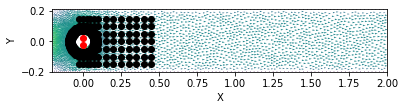

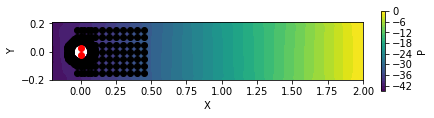

In [11]:
env.show_flow()

In [31]:
env.visual_inspection()

Simu_lift | Ep N:    0, step: 20000, Rec Area: 0.0117, drag: -0.1586, lift: 0.0163


In [36]:
env = resume_env(plot=1, dump=10, single_run=True)

-0.2 0.21


In [15]:
constant_profile(convert('turek_2d.msh','turek_2d.h5'),degree=2)

RuntimeError: Expecting a mesh as keyword argument

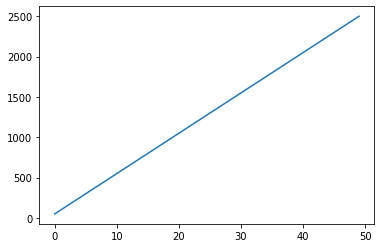

In [41]:
c=[]
a=4
b=1
for i in range(50):
    a=50 * (i+1)
    c.append(a)
plt.plot(c)